# 1. Install Dependencies and Setup

In [198]:
import tensorflow as tf
import os

In [199]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [200]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [201]:
data_dir = 'data'

In [202]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))            

# Load Data

In [211]:
import numpy as np

In [318]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

j = 0
for image in os.listdir('data/pure/'):
    img = load_img('data/pure/'+image)
    x = img_to_array(img)  
    x = x.reshape((1,)+x.shape)  
    
    j += 1
    i = 0
    for batch in datagen.flow(x, batch_size=32, save_to_dir='augmented/pure_augmented', save_prefix='pure'+str(j), save_format='jpeg'):
        i += 1
        if i > 20:
            break 
            
j = 0

for image in os.listdir('data/mixed/'):
    img = load_img('data/mixed/'+image)
    x = img_to_array(img)  
    x = x.reshape((1,)+x.shape)  
    
    j += 1
    i = 0
    for batch in datagen.flow(x, batch_size=32, save_to_dir='augmented/mixed_augmented', save_prefix='mixed'+str(j), save_format='jpeg'):
        i += 1
        if i > 20:
            break 

In [319]:
data = tf.keras.utils.image_dataset_from_directory('augmented')

Found 1008 files belonging to 2 classes.


# 2. Preprocess Data

## 2.1 Scaling images

In [320]:
data = data.map(lambda x,y: (x/255, y))

## 2.2 Split Data

In [321]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [322]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 3. Model

## 3.1 Build the model

In [323]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [324]:
model = Sequential()

In [325]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [326]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [327]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 16)      

## 3.2 Train the model

In [328]:
logdir='logs'

In [329]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [330]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
22/22 [==============================] - 15s 664ms/step - loss: 0.5777 - accuracy: 0.7358 - val_loss: 0.4844 - val_accuracy: 0.7991
Epoch 2/20
22/22 [==============================] - 14s 648ms/step - loss: 0.5312 - accuracy: 0.7642 - val_loss: 0.5272 - val_accuracy: 0.7902
Epoch 3/20
22/22 [==============================] - 15s 648ms/step - loss: 0.4902 - accuracy: 0.7898 - val_loss: 0.4911 - val_accuracy: 0.7768
Epoch 4/20
22/22 [==============================] - 16s 705ms/step - loss: 0.4423 - accuracy: 0.8040 - val_loss: 0.4182 - val_accuracy: 0.8348
Epoch 5/20
22/22 [==============================] - 15s 681ms/step - loss: 0.3956 - accuracy: 0.8366 - val_loss: 0.3976 - val_accuracy: 0.8482
Epoch 6/20
22/22 [==============================] - 16s 692ms/step - loss: 0.3511 - accuracy: 0.8537 - val_loss: 0.4063 - val_accuracy: 0.8482
Epoch 7/20
22/22 [==============================] - 15s 687ms/step - loss: 0.3172 - accuracy: 0.8665 - val_loss: 0.4266 - val_accuracy: 0.8304

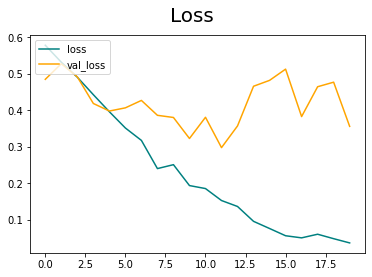

In [331]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


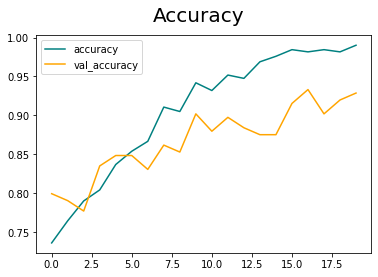

In [332]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 3.3 Model Evaluation

In [333]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [334]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [335]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 75ms/step


In [336]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.95, shape=(), dtype=float32) tf.Tensor(0.91935486, shape=(), dtype=float32) tf.Tensor(0.9, shape=(), dtype=float32)


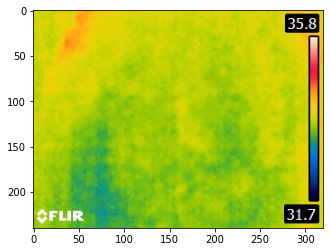

In [337]:
img = cv2.imread('test/mixed.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

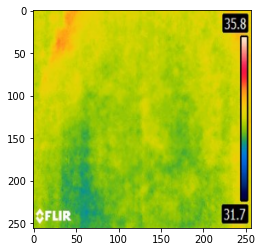

In [338]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [339]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [340]:
yhat

array([[0.03500246]], dtype=float32)

In [341]:
if yhat > 0.5: 
    print(f'Predicted class is Pure')
else:
    print(f'Predicted class is Mixed')

Predicted class is Mixed


# 4. Saving the model

In [342]:
from tensorflow.keras.models import load_model

In [343]:
model.save(os.path.join('models','imageclassifier.h5'))

In [344]:
new_model = load_model('models/imageclassifier.h5')

In [345]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 67ms/step


array([[0.03500246]], dtype=float32)